En este notebook implementamos la simulación numérica de un modelo de difusión en grafos no dirigidos y simples. El modelo que implementamos es

$$
\dot{C}(t) = L^TC(t)=BB^T C(t)  \tag{1}
$$

Donde:

* $C(t)$ es el vector de concentraciones; nos indica cuánta información tiene cierto nodo en un tiempo $t$.

* $\dot{C}(t)$ es el vector del cambio en las concentraciones del vector de concentraciones.

* $L$ es la matriz Laplaciana del grafo.

* $B$ es la matriz de incidencia para **grafos dirigidos**, aquella que tiene unos positivos y negativos asi como ceros ceros. Es de tamaño $|V| \times |E|$.

Hacemos la simulacion en el caso discreto y continuo.

In [50]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import string

# Funciones en común

In [55]:
#Aqui hacemos un diccionario en el que hacemos la relacion de cada letra con su posicion en el abecedario
def Diccionario(num_letters):
    # Obtener las letras del alfabeto en mayúsculas
    letters = string.ascii_uppercase

    # Verificar que el número de letras no exceda el número total de letras disponibles
    if num_letters > len(letters):
        raise ValueError(f"El número de letras solicitado ({num_letters}) excede el total disponible ({len(letters)})")

    # Crear el diccionario con las letras y los valores
    letter_dict = {letters[i]: i  for i in range(num_letters)}

    inverted_dict = {value: key for key, value in letter_dict.items()}

    return inverted_dict

In [56]:
#Diremos que el proceso converge si cada una de las entradas del vector que resulta al resta C(t)-C(t-1) en valor absoluto
#es menor a la tolerancia dada
def Criterio_Paro(V1,V2,Tol):
  if np.all(np.abs(V1-V2)<Tol):
    return True
  return False

#Conservativa en tiempo continuo

In [95]:
"""
La función recibe los siguientes parámetros:

A (Array de NumPy bidimensional): Matriz de adyacencia.
d (Array de NumPy unidimensional): Array con los coeficientes de difusión.
C0 (Array de NumPy unidimensional): Vector de concentraciones iniciales.
Tiempo (Entero positivo): Cantidad de tiempo que se desea simular.
Tolerancia (Número entero o float positivo): Tolerancia para el criterio de paro.
Semilla (Número entero positivo): Una semilla para reproducir resultados aleatorios.
K (Número positivo): Es un parámetro que sirve para la visualización, controla qué tan separados estarán los vértices al imprimir el grafo.
Escalar (True o False): Es un parámetro para la visualización 3D. Si es True, se plotea el grafo en 3D con las curvaturas sobre las aristas de tal forma que aparecen en una altura de 0 a 1. Si es False, aparecen por debajo de las aristas tan profundamente como el valor de la curvatura de esa arista.

La función tiene algunas partes comentadas que sirven para mostrar información de matrices, vectores o ciertas cantidades. Si se trabaja con dimensiones pequeñas, es útil para ver el proceso. Con matrices de dimensiones altas no es viable descomentarlas, ya que tardaría demasiado en imprimir la información.
"""

def DifusionContinua(A,C0,Tiempo,Tolerancia):

  #Obtenemos las etiquetas de los vertices usando la funcion Diccionario
  Etiquetas = Diccionario(len(C0))

  # Hacemos un grafo a partir de la matriz de adyacencia
  G = nx.convert_matrix.from_numpy_array(A)

  #Asignamos las etiquetas a los vertices
  G = nx.relabel_nodes(G, Etiquetas)

  #Obtenemos la matriz Laplaciana
  L=nx.laplacian_matrix(G)
  L = L.toarray()

  #Obtenemos la matriz de incidencia dirigida, la que tienes unos, menos unos y ceros
  B=nx.incidence_matrix(G, oriented=True).toarray()

  #Enumeramos las aristas, edge nos regresara duplas tipo ('A','B') ('E','G'), con el indice i las enumeraremos alfabeticamente, hacemos esto para darle los nombres a las columnas de la tabla
  #de flujos que calculamos mas adelante
  aristas = {edge: f"{i+1}" for i, edge in enumerate(G.edges())}

  # Obtenemos los eigenvalores y eigenvectores
  eigenvalores, eigenvectores = np.linalg.eig(L)

  """
  El método para obtener los eigenvalores y eigenvectores a veces detecta números complejos muy pequeños
  que, en realidad, deberían ser cero. Matemáticamente, los eigenvalores y eigenvectores de estas matrices
  no son complejos, por lo que nos quedamos con la parte real para evitar problemas.
  """

  eigenvalores=np.real(eigenvalores)
  eigenvectores=np.real(eigenvectores)

  #Si nos interesa conocer los eigenvalores o eigenvectores descomentamos esta parte

  """
  print("Los eigenvalores ordenados de menor a mayor son :\n")
  print(np.sort(eigenvalores))
  print("Los eigenvectores son:")
  print(eigenvectores)
  """

  #Para presentar la evolución del proceso haremos un dataframe en donde el indice sea el tiempo y las columnas representen la cantidad de concentración en ese vertice.
  Evolucion = pd.DataFrame(columns=list(Etiquetas.values()))

  #Ademas podemos obtener un dataframe del flujo que se calcula usando dB^TC(t) , esta tabla nos dira cuanta concentracion pasa por las aristas en un tiempo t
  Flujo=pd.DataFrame(columns=list(aristas.keys()))


  #Ahora definimos cuantos puntos en el intervalo de tiempo (0,Tiempo) queremos analizar, es decir, cuantos tiempos t dentro de ese intervalo usaremos para calcular
  #su respectivo C(t), como estamos en el caso continuo se recomienda que sean bastantes. Nosotros definimos por default 60 pero puede ajustarse
  S=60
  T = np.linspace(0, Tiempo, num=S)

  #Obtengo la inversa de la matriz de eigenvectores
  eigenvectoresInv=np.linalg.inv(eigenvectores)


  #Este for es el que simula el proceso, en cada t calculamos el vector C(t) asi como el flujo de las aristas y las guardamos en sus dataframes, usaremos tantas t como
  #hayamos definido o acabara antes si se considera que el proceso ya alcanzo un estado de estabilidad
  for t in T :
    Ct=np.zeros(len(C0))
    e_i=np.real(np.exp(-t*eigenvalores))
    for i in range(len(eigenvectores)):
      eigenvectores[:,i] = eigenvectores[:,i] / np.linalg.norm(eigenvectores[:,i])
      K=np.dot(eigenvectores[:,i],C0.reshape(-1,1))
      Ct=np.real(Ct+eigenvectores[:,i]*K*e_i[i])
    Evolucion.loc[len(Evolucion)] = Ct
    Flujo.loc[len(Flujo)] = np.dot(B.T,Ct)
    #Enviamos a la funcion Criterio_Paro el vector C(t) y C(t-1) para ver si podemos detener el proceso. Hacemos esto para todas las iteraciones despues de la primera
    if t!=0 and Criterio_Paro(Evolucion.iloc[len(Evolucion)-1].to_numpy(),Evolucion.iloc[len(Evolucion)-2].to_numpy(),Tolerancia):
      break

  #En esta seccion imprimimos la informacion resumida
  print("Vector de concentraciones inicial: ",C0)

  print("\nEvolucion del vector de concentraciones: \n")

  #Aqui le damos un poco de formato a las tablas colocando los indices temporales
  Evolucion["Tiempo"]=T[:len(Evolucion)]
  Evolucion=Evolucion.set_index("Tiempo")
  Flujo["Tiempo"]=T[:len(Flujo)]
  Flujo=Flujo.set_index("Tiempo")
  print(Evolucion)
  print(Flujo)

  #Mostramos la grafica de como fueron cambiando las concentraciones
  print("\nLa grafica es :")

  pos = nx.spring_layout(G)  # Posicionamiento de los nodos, solo hace que no haya tantas intersecciones entre aristas
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color='black', font_size=15, font_weight='bold')

  Evolucion.plot(figsize=(10, 6))
  plt.xlabel('Tiempo')
  plt.ylabel('Concentración')
  plt.title('Evolución de concentraciones en el tiempo')
  plt.legend()
  plt.grid()
  plt.show()

Vector de concentraciones inicial:  [3 2 5 4 2 3 5 3 6 1]

Evolucion del vector de concentraciones: 

                 A         B         C         D         E         F  \
Tiempo                                                                 
0.000000  3.493779  2.493779  4.506221  4.493779  3.274977  1.725023   
0.338983  3.034720  2.994890  4.075094  4.345073  2.810866  2.726313   
0.677966  3.023510  3.144762  3.868559  4.129916  2.921304  3.075063   
1.016949  3.093542  3.229401  3.741759  3.952045  3.057356  3.227408   
1.355932  3.164595  3.286368  3.656276  3.816276  3.158124  3.304038   
1.694915  3.222215  3.324833  3.595614  3.714214  3.228204  3.345426   
2.033898  3.266378  3.350442  3.550940  3.637618  3.276879  3.368569   
2.372881  3.299655  3.367351  3.517164  3.580040  3.311018  3.381755   
2.711864  3.324599  3.378482  3.491193  3.536652  3.335218  3.389361   
3.050847  3.343278  3.385807  3.471030  3.503876  3.352538  3.393789   
3.389831  3.357271  3.390631  3.45

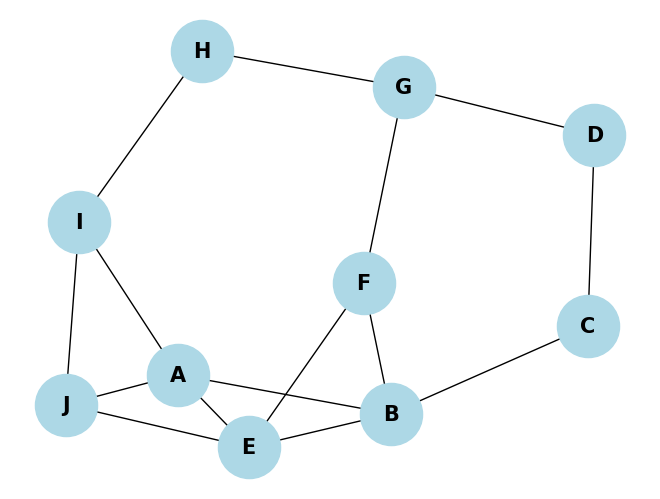

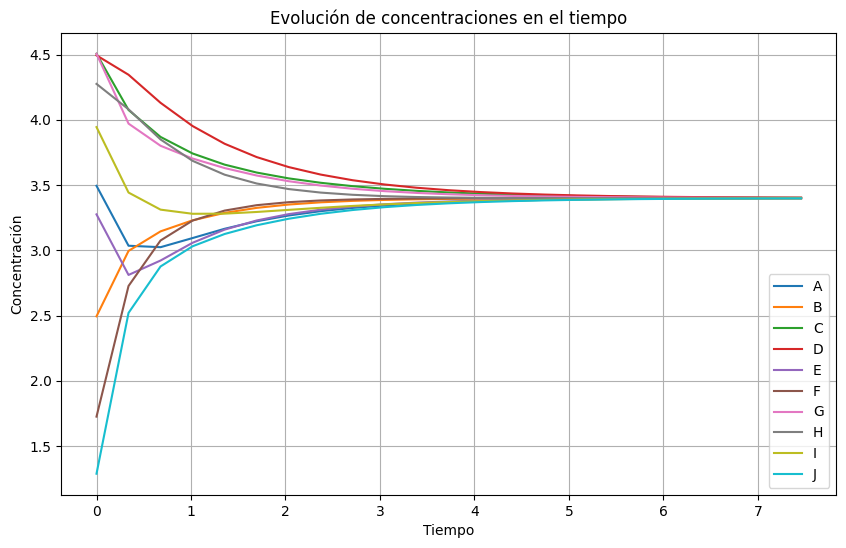

In [96]:
A = np.array([
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
])

C0=np.array([3,2,5,4,2,3,5,3,6,1])
Tiempo=20
Tolerancia=0.001

DifusionContinua(A,C0,Tiempo,Tolerancia)

#Conservativa en tiempo discreto

En ocasiones, nos gustaría ver cómo se desarrolla la evolución en un sistema que funciona en tiempo discreto, por ejemplo, cómo avanza una enfermedad cada semana. La discretización de (1) es:


$$
    C(t+\Delta t)=PC(t) \tag{2}
$$

Donde $ P $ es una matriz definida como $ P = I - \Delta t L $. Aquí, $ \Delta t $ representa la cantidad de tiempo entre cada iteración.

In [97]:
"""
La función recibe:

- A (Matriz de NumPy): Matriz de adyacencia del grafo.
- C0 (Vector de NumPy): Vector de concentraciones iniciales.
- Delta (Número racional): Parámetro que indica cuánto avanzamos en el tiempo en cada iteración.
- Tolerancia (Número decimal): Umbral para decidir si continuar con el proceso o detenerlo.
- Iteraciones (Número entero positivo): Cantidad máxima de iteraciones del proceso.
"""
def DifusionDiscreta(A,C0,Delta,Tolerancia,Iteraciones):

  #Obtenemos un grafo a partir de una matriz de adyacencia
  G = nx.convert_matrix.from_numpy_array(A)

  #Obtenemos las etiquetas de los vertices (A,B,C...) usando la funcion Diccionario
  Etiquetas = Diccionario(len(C0))

  #Asignamos las etiquetas a los vertices
  G = nx.relabel_nodes(G, Etiquetas)

  #Obtenemos la matriz laplaciana
  L=nx.laplacian_matrix(G)
  L = L.toarray()

  #Creamos una matriz identidad
  I=np.identity(A.shape[0])

  #Hacemos la matriz P
  P=I-Delta*L

  #Calculamos el vector que se alcanza cuando
  Estable = np.full(len(C0), np.sum(C0)/len(C0))

  Evolucion= pd.DataFrame([C0], columns=Etiquetas.values())
  #Vamos a pasarlo como parametro Tolerancia=0.1
  for t in range(Iteraciones):

    #Calculamos el vector de concentraciones y lo añadimos al historial
    C0=np.dot(P,C0)
    Evolucion.loc[len(Evolucion)] = C0

    #Enviamos a la funcion Criterio_Paro el vector C(t) y C(t-1) para ver si podemos detener el proceso. Hacemos esto para todas las iteraciones despues de la primera
    if t!=0 and Criterio_Paro(Evolucion.iloc[len(Evolucion)-1].to_numpy(),Evolucion.iloc[len(Evolucion)-2].to_numpy(),Tolerancia):
      break

  #Imprimimos el proceso en tabla
  print(Evolucion)

  #Sacamos colores para el ploteo
  colores = plt.cm.get_cmap('tab20', 20).colors

  for i, vertice in enumerate(Evolucion.columns):
    plt.plot(Evolucion.index, Evolucion[vertice], marker='o', color=colores[i], label=vertice)
  plt.legend()
  plt.grid()
  plt.show()


  #Ploteamos el grafo
  nx.draw(G, with_labels=True,node_color='skyblue', node_size=1500, font_size=12, font_color='black')
  plt.show()



            A         B         C         D         E         F         G  \
0   10.000000  5.000000  8.000000  3.000000  7.000000  4.000000  6.000000   
1    8.600000  6.200000  7.600000  4.400000  5.600000  5.800000  6.400000   
2    7.920000  6.600000  7.120000  5.280000  5.960000  5.920000  6.320000   
3    7.496000  6.704000  6.944000  5.808000  6.120000  6.072000  6.280000   
4    7.227200  6.731200  6.841600  6.102400  6.244800  6.171200  6.265600   
5    7.050880  6.726720  6.777280  6.270400  6.325120  6.240000  6.272640   
6    6.931328  6.710400  6.731456  6.366528  6.377088  6.289024  6.289472   
7    6.847168  6.690022  6.696346  6.421914  6.410714  6.325363  6.309952   
8    6.785574  6.669094  6.668119  6.453985  6.432858  6.353293  6.330900   
9    6.738787  6.649174  6.644753  6.472643  6.447831  6.375442  6.350825   
10   6.702058  6.630906  6.625060  6.483547  6.458299  6.393457  6.369094   
11   6.672428  6.614495  6.608276  6.489951  6.465891  6.408395  6.385505   

<ipython-input-97-5a956ed3122a>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab20', 20).colors


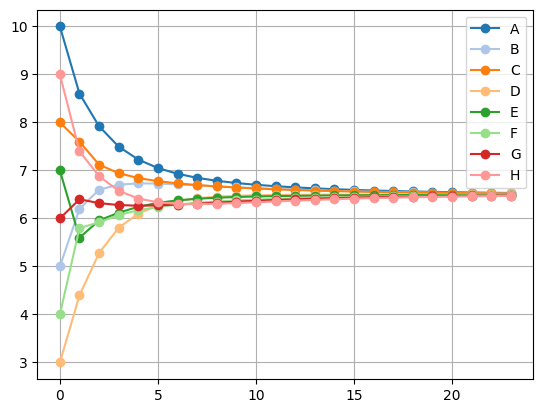

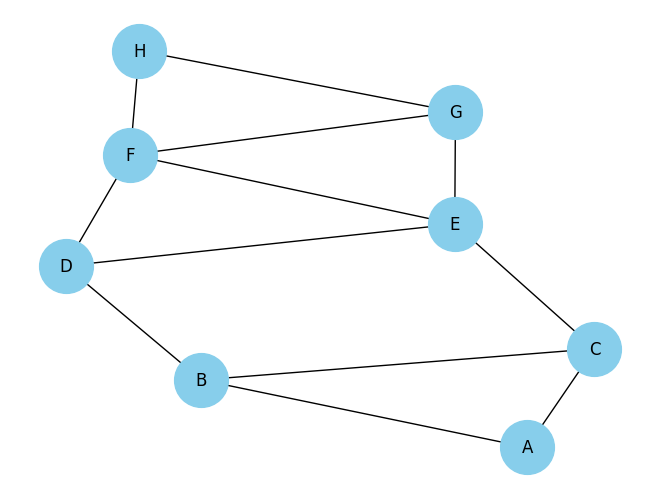

In [98]:
A = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 0]
])

C0 = np.array([10, 5, 8, 3, 7, 4, 6, 9])

Delta = 0.2
Tolerancia = 0.005
Iteraciones = 50

DifusionDiscreta(A, C0, Delta, Tolerancia, Iteraciones)